## Importing libraries

In [1]:
# import initial libraries
import pandas as pd
import numpy as np
from numpy import NaN
import seaborn as sns
from scipy import stats
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
import nltk

## Importing data

In [2]:
train = pd.read_csv('/Users/dad/Downloads/mercari-price-suggestion-challenge/train.tsv', sep = '\t', low_memory=True)
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

## EDA & Feature Engineering

In [3]:
#function to get all info in one go
def full_info(df):
    df_column=[]
    df_dtype=[]
    df_null=[]
    df_nullc=[]
    df_mean=[]
    df_median=[]
    df_std=[]
    df_min=[]
    df_max=[]
    df_uniq=[]
    df_count=[]
    for col in df.columns: 
        df_column.append(  col )
        df_dtype.append( df[col].dtype)
        df_null.append( round(100 * df[col].isnull().sum(axis=0)/len(df[col]),2))
        df_nullc.append( df[col].isnull().sum(axis=0))
        df_uniq.append( df[col].nunique()) if df[col].dtype == 'object' else df_uniq.append( NaN)
        df_mean.append(  '{0:.2f}'.format(df[col].mean())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_mean.append( NaN)
        df_median.append( '{0:.2f}'.format(df[col].median())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_median.append( NaN)
        df_std.append( '{0:.2f}'.format(df[col].std())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_std.append( NaN)
        df_max.append( '{0:.2f}'.format(df[col].max())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_max.append( NaN)
        df_min.append( '{0:.2f}'.format(df[col].min())) if df[col].dtype == 'int64' or df[col].dtype == 'float64' else df_min.append( NaN)
        df_count.append(df[col].count())
    return pd.DataFrame(data = {'ColName':  df_column, 'ColType': df_dtype, 'NullCnt': df_nullc, 'NullCntPrcntg': df_null,  'Min': df_min, 'Max': df_max, 'Mean': df_mean, 'Med': df_median, 'Std': df_std, 'UniqCnt': df_uniq, 'ColValCnt': df_count})


In [4]:
# lets get full desciption of the data
full_info(train)

ColName  ColType  NullCnt  NullCntPrcntg   Min         Max  \
0           train_id    int64        0           0.00  0.00  1482534.00   
1               name   object        0           0.00   NaN         NaN   
2  item_condition_id    int64        0           0.00  1.00        5.00   
3      category_name   object     6327           0.43   NaN         NaN   
4         brand_name   object   632682          42.68   NaN         NaN   
5              price  float64        0           0.00  0.00     2009.00   
6           shipping    int64        0           0.00  0.00        1.00   
7   item_description   object        4           0.00   NaN         NaN   

        Mean        Med        Std    UniqCnt  ColValCnt  
0  741267.00  741267.00  427971.14        NaN    1482535  
1        NaN        NaN        NaN  1225273.0    1482535  
2       1.91       2.00       0.90        NaN    1482535  
3        NaN        NaN        NaN     1287.0    1476208  
4        NaN        NaN        NaN     4809.0     849853  
5      26.74      17.00      38.59        NaN    1482535  
6       0.45       0.00       0.50        NaN    1482535  
7        NaN        NaN        NaN  1281426.0    1482531

In [5]:
print(train['category_name'].str.count('/').min())
print(train['category_name'].str.count('/').max())

2.0
4.0


In [6]:
# lets split the category into category splits
train_sp = train.join(train['category_name'].str.split('/', expand=True).add_prefix('category_split_'))

# and lets see how the data looks
train_sp.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  \
0         1                                 No description yet   
1         0  This keyboard is in great condition and works ...   
2         1  Adorable top with a hint of lace and a key hol...   
3         1  New with tags. Leather horses. Retail for [rm]...   
4         0          Complete with certificate of authenticity   

  category_split_0     category_split_1    category_split_2 category_split_3  \
0              Men                 Tops            T-shirts             None   
1      Electronics  Computers & Tablets  Components & Parts             None   
2            Women       Tops & Blouses              Blouse             None   
3             Home           Home Décor  Home Décor Accents             None   
4            Women              Jewelry           Necklaces             None   

  category_split_4  
0             None  
1             None  
2             None  
3             None  
4             None

In [7]:
# lets get full desciption of the data again
train_sp_info= full_info(train_sp)
train_sp_info

ColName  ColType  NullCnt  NullCntPrcntg   Min         Max  \
0            train_id    int64        0           0.00  0.00  1482534.00   
1                name   object        0           0.00   NaN         NaN   
2   item_condition_id    int64        0           0.00  1.00        5.00   
3       category_name   object     6327           0.43   NaN         NaN   
4          brand_name   object   632682          42.68   NaN         NaN   
5               price  float64        0           0.00  0.00     2009.00   
6            shipping    int64        0           0.00  0.00        1.00   
7    item_description   object        4           0.00   NaN         NaN   
8    category_split_0   object     6327           0.43   NaN         NaN   
9    category_split_1   object     6327           0.43   NaN         NaN   
10   category_split_2   object     6327           0.43   NaN         NaN   
11   category_split_3   object  1478146          99.70   NaN         NaN   
12   category_split_4   object  1479476          99.79   NaN         NaN   

         Mean        Med        Std    UniqCnt  ColValCnt  
0   741267.00  741267.00  427971.14        NaN    1482535  
1         NaN        NaN        NaN  1225273.0    1482535  
2        1.91       2.00       0.90        NaN    1482535  
3         NaN        NaN        NaN     1287.0    1476208  
4         NaN        NaN        NaN     4809.0     849853  
5       26.74      17.00      38.59        NaN    1482535  
6        0.45       0.00       0.50        NaN    1482535  
7         NaN        NaN        NaN  1281426.0    1482531  
8         NaN        NaN        NaN       10.0    1476208  
9         NaN        NaN        NaN      113.0    1476208  
10        NaN        NaN        NaN      870.0    1476208  
11        NaN        NaN        NaN        7.0       4389  
12        NaN        NaN        NaN        3.0       3059

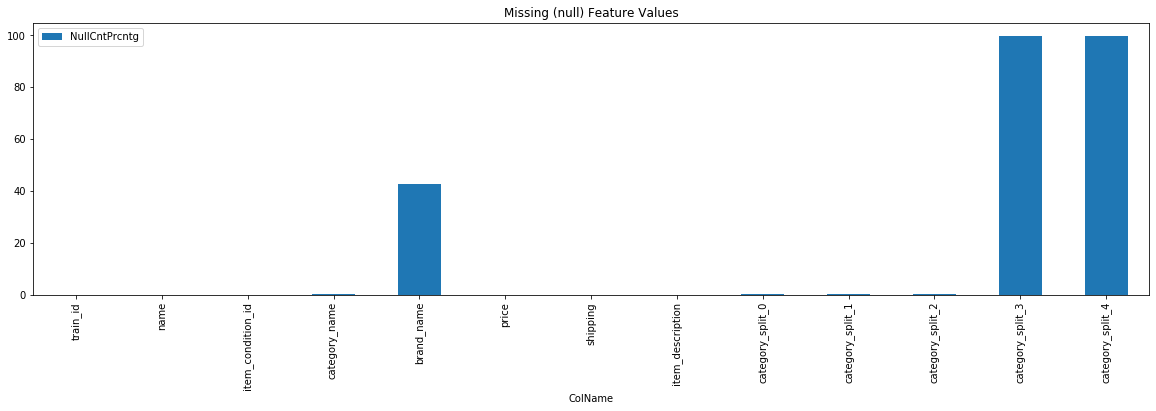

In [8]:
# lets visualize the Null Count percentage graphically
train_sp_info.plot.bar(x = 'ColName', y = 'NullCntPrcntg', figsize=(20, 5),rot=90, title='Missing (null) Feature Values')
plt.show()

In [9]:
# lets drop the category_split_3 and category_split_4 as they have most nulls. lets keep the brand for now.
train_sp_trim=train_sp.drop(['category_split_3', 'category_split_4'],axis=1)
# lets see how the data looks like now
train_sp_trim

train_id                                   name  item_condition_id  \
0               0    MLB Cincinnati Reds T Shirt Size XL                  3   
1               1       Razer BlackWidow Chroma Keyboard                  3   
2               2                         AVA-VIV Blouse                  1   
3               3                  Leather Horse Statues                  1   
4               4                   24K GOLD plated rose                  1   
...           ...                                    ...                ...   
1482530   1482530             Free People Inspired Dress                  2   
1482531   1482531          Little mermaid handmade dress                  2   
1482532   1482532  21 day fix containers and eating plan                  2   
1482533   1482533                 World markets lanterns                  3   
1482534   1482534          Brand new lux de ville wallet                  1   

                                             category_name   brand_name  \
0                                        Men/Tops/T-shirts          NaN   
1        Electronics/Computers & Tablets/Components & P...        Razer   
2                              Women/Tops & Blouses/Blouse       Target   
3                       Home/Home Décor/Home Décor Accents          NaN   
4                                  Women/Jewelry/Necklaces          NaN   
...                                                    ...          ...   
1482530                             Women/Dresses/Mid-Calf  Free People   
1482531                           Kids/Girls 2T-5T/Dresses       Disney   
1482532     Sports & Outdoors/Exercise/Fitness accessories          NaN   
1482533                 Home/Home Décor/Home Décor Accents          NaN   
1482534                  Women/Women's Accessories/Wallets          NaN   

         price  shipping                                   item_description  \
0         10.0         1                                 No description yet   
1         52.0         0  This keyboard is in great condition and works ...   
2         10.0         1  Adorable top with a hint of lace and a key hol...   
3         35.0         1  New with tags. Leather horses. Retail for [rm]...   
4         44.0         0          Complete with certificate of authenticity   
...        ...       ...                                                ...   
1482530   20.0         1  Lace, says size small but fits medium perfectl...   
1482531   14.0         0   Little mermaid handmade dress never worn size 2t   
1482532   12.0         0          Used once or twice, still in great shape.   
1482533   45.0         1  There is 2 of each one that you see! So 2 red ...   
1482534   22.0         0  New with tag, red with sparkle. Firm price, no...   

          category_split_0     category_split_1     category_split_2  
0                      Men                 Tops             T-shirts  
1              Electronics  Computers & Tablets   Components & Parts  
2                    Women       Tops & Blouses               Blouse  
3                     Home           Home Décor   Home Décor Accents  
4                    Women              Jewelry            Necklaces  
...                    ...                  ...                  ...  
1482530              Women              Dresses             Mid-Calf  
1482531               Kids          Girls 2T-5T              Dresses  
1482532  Sports & Outdoors             Exercise  Fitness accessories  
1482533               Home           Home Décor   Home Décor Accents  
1482534              Women  Women's Accessories              Wallets  

[1482535 rows x 11 columns]

In [10]:
# lets remove the items with price of $0 as well as they are of no use in price prediction
train_sp_trim = train_sp_trim[train_sp_trim.price != 0]


In [11]:
# Create a function to impute missing values
def fill_missing_value(df):
    df['category_split_0'].fillna(value = 'unknown', inplace=True)
    df['category_split_1'].fillna(value = 'unknown', inplace=True)
    df['category_split_2'].fillna(value = 'unknown', inplace=True)
    df['brand_name'].fillna(value = 'unknown', inplace=True)
    df['category_name'].fillna(value = 'unknown', inplace=True)
    df['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return df

In [12]:
# lets apply the fill_missing_value function on the data to fill the nulls
train_fill = fill_missing_value(train_sp_trim)

# lets get full desciption of the data again
full_info(train_fill)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ColName  ColType  NullCnt  NullCntPrcntg   Min         Max  \
0            train_id    int64        0            0.0  0.00  1482534.00   
1                name   object        0            0.0   NaN         NaN   
2   item_condition_id    int64        0            0.0  1.00        5.00   
3       category_name   object        0            0.0   NaN         NaN   
4          brand_name   object        0            0.0   NaN         NaN   
5               price  float64        0            0.0  3.00     2009.00   
6            shipping    int64        0            0.0  0.00        1.00   
7    item_description   object        0            0.0   NaN         NaN   
8    category_split_0   object        0            0.0   NaN         NaN   
9    category_split_1   object        0            0.0   NaN         NaN   
10   category_split_2   object        0            0.0   NaN         NaN   

         Mean        Med        Std    UniqCnt  ColValCnt  
0   741243.72  741238.00  427971.46        NaN    1481661  
1         NaN        NaN        NaN  1224596.0    1481661  
2        1.91       2.00       0.90        NaN    1481661  
3         NaN        NaN        NaN     1288.0    1481661  
4         NaN        NaN        NaN     4808.0    1481661  
5       26.75      17.00      38.59        NaN    1481661  
6        0.45       0.00       0.50        NaN    1481661  
7         NaN        NaN        NaN  1280671.0    1481661  
8         NaN        NaN        NaN       11.0    1481661  
9         NaN        NaN        NaN      114.0    1481661  
10        NaN        NaN        NaN      871.0    1481661

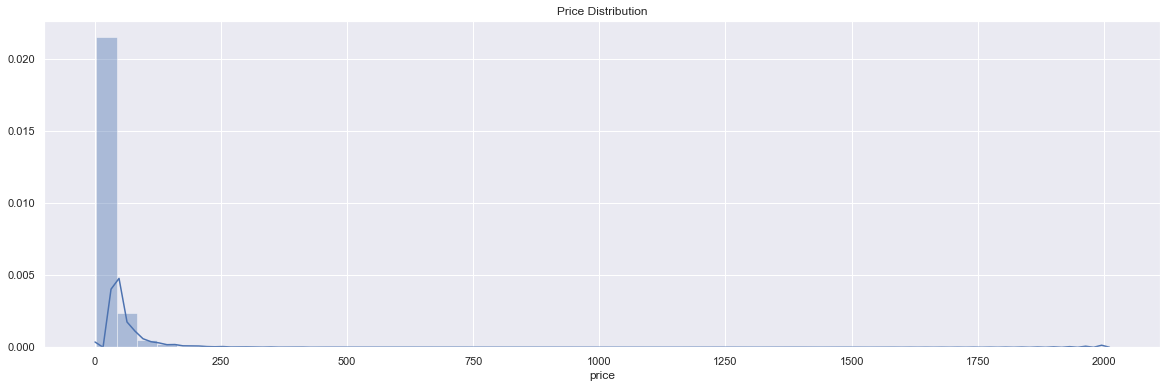

In [13]:
# lets see the price distribution visually
plt.figure(figsize=(20, 6))
sns.set()
sns.distplot(train_fill['price'], bins = 50)
plt.title('Price Distribution', fontsize=12);

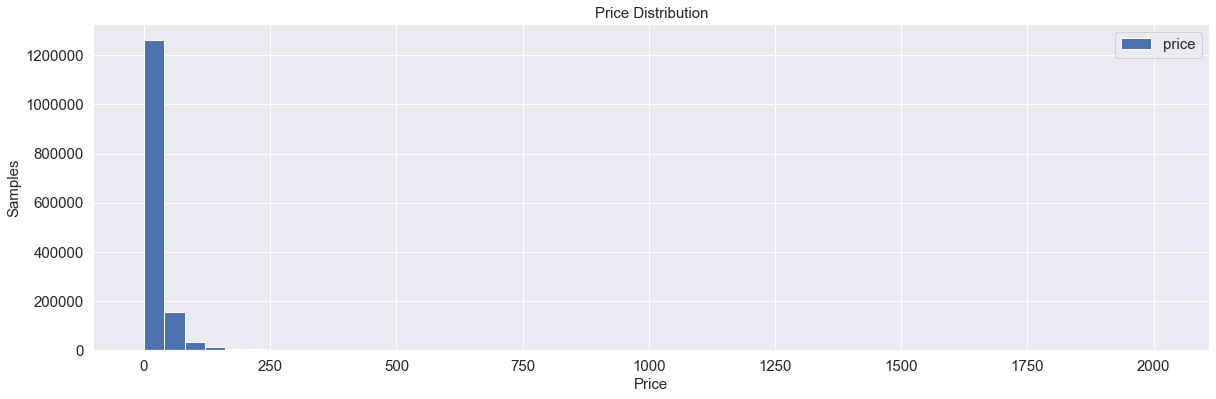

In [14]:
plt.figure(figsize=(20, 6))
plt.hist(train_fill['price'], bins=50, range=[0,2010], label='price')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

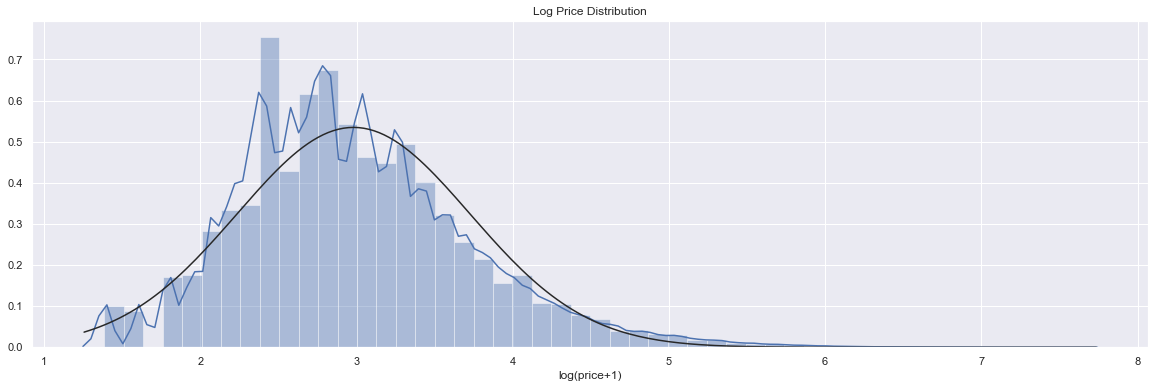

In [15]:
plt.figure(figsize=(20, 6))
sns.distplot(np.log(train_fill['price']+1), fit = stats.norm)
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12);

In [16]:
# lets see by brand name how its priced
brand = train_fill.groupby('brand_name').price.agg(['count','mean'])
brand = brand[brand['count']>1000].sort_values(by='mean', ascending=False)
brand.head(30)

count        mean
brand_name                            
Louis Vuitton         3187  202.187637
Gucci                 1857   97.070005
Air Jordan            3509   96.198632
Tiffany & Co.         1256   84.102707
Tory Burch            3447   81.771976
Chanel                2353   74.770081
Beats                 1249   73.568455
Apple                17314   73.302472
Jordan                1862   71.080559
Beats by Dr. Dre      1015   69.953695
Kendra Scott          5096   66.031888
Michael Kors         13916   62.308458
Dooney & Bourke       1751   60.342090
Kate Spade            5409   58.001387
Rock Revival          1874   57.356990
Samsung               4073   57.115885
Fitbit                2028   56.747041
UGG Australia         4673   54.976889
Supreme               1232   53.089286
Ray-Ban               1841   50.551874
Stamped               1255   49.621514
patagonia             1807   47.498063
Lululemon            14550   47.122612
PUMA                  1682   46.616528
lululemon athletica   1008   44.366071
Adidas               10195   43.156940
Lilly Pulitzer        2974   42.945528
Coach                10458   41.162220
Fuji                  1015   40.188177
American Boy & Girl   2481   39.779927

In [17]:
# lets visualize the count by brand name
brand = train_fill['brand_name'].value_counts()
fig = go.Figure([go.Pie(labels=brand.keys(), values=brand)])
fig.update_traces( hoverinfo="label+percent")
fig.update_layout(title_text="% by Brand")
fig.show()

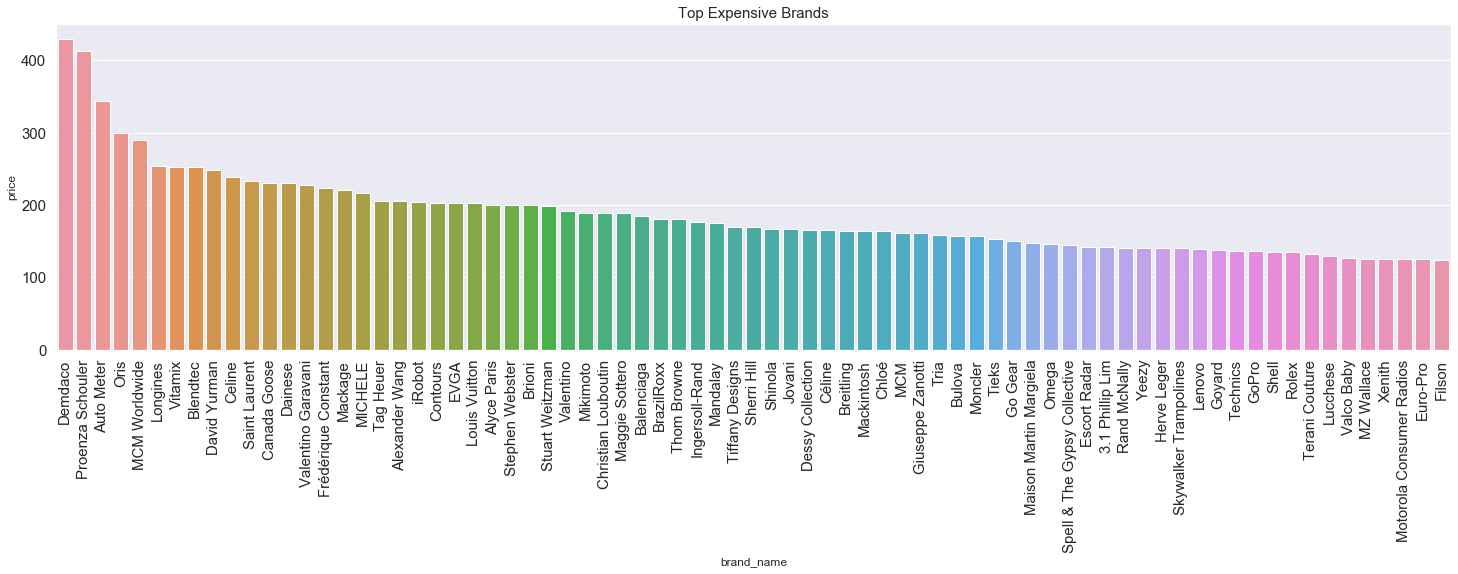

In [18]:
# lets visualize Top 75 Expensive Brands By Mean Price
plt.figure(figsize=(25, 6))
top_brands = train_fill.groupby('brand_name', axis=0).mean()
df_expPrice = pd.DataFrame(top_brands.sort_values('price', ascending = False)['price'][0:75].reset_index())


ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top Expensive Brands', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [19]:
# lets see by main category how its priced
maincat = train_fill.groupby('category_split_0').price.agg(['count','mean'])
maincat = maincat[maincat['count']>1000].sort_values(by='mean', ascending=False)
maincat.head(30)

count       mean
category_split_0                         
Electronics             122632  35.190558
Men                      93609  34.734940
Women                   663990  28.902679
Vintage & Collectibles   46519  27.345891
Sports & Outdoors        25322  25.552385
unknown                   6314  25.446943
Home                     67831  24.551068
Other                    45329  20.819917
Kids                    171555  20.658439
Beauty                  207725  19.681290
Handmade                 30835  18.160694

In [20]:
# lets visualize the count by main category or category_split_0
categories = train_fill['category_split_0'].value_counts()
fig = go.Figure([go.Pie(labels=categories.keys(), values=categories)])
fig.update_traces( hoverinfo="label+percent")
fig.update_layout(title_text="% by Main Category")
fig.show()

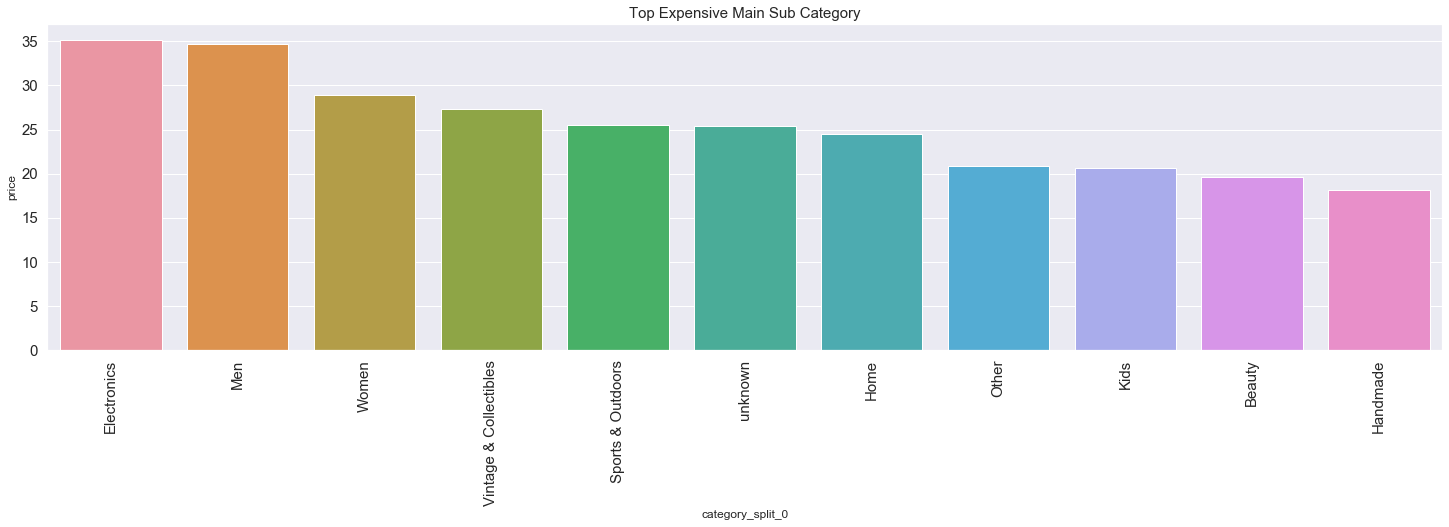

In [21]:
# lets visualize Top 75 category_split_0 By Mean Price
plt.figure(figsize=(25, 6))
category = train_fill.groupby('category_split_0', axis=0).mean()
df_expPrice = pd.DataFrame(category.sort_values('price', ascending = False)['price'][0:75].reset_index())
result = df_expPrice.groupby(["category_split_0"])['price'].aggregate(np.median).reset_index().sort_values('price')

ax = sns.barplot(x="category_split_0", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top Expensive Main Sub Category', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

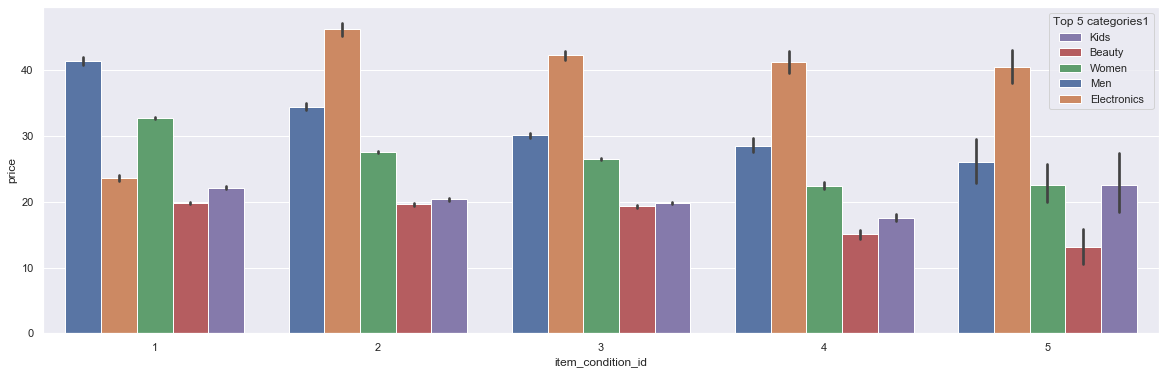

In [22]:
#price comparison by item condition across 5 most frequent Main Categories
plt.figure(figsize=(20, 6))
sns.barplot(x='item_condition_id', y="price", hue='category_split_0', data=train_fill[(train_fill['category_split_0'] == train_fill['category_split_0'].value_counts().index[0]) | (train_fill['category_split_0'] == train_fill['category_split_0'].value_counts().index[1]) | (train_fill['category_split_0'] == train_fill['category_split_0'].value_counts().index[2]) | (train_fill['category_split_0'] == train_fill['category_split_0'].value_counts().index[3]) | (train_fill['category_split_0'] == train_fill['category_split_0'].value_counts().index[4])])
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[4], handles[3], handles[2], handles[0], handles[1]]
labels = [labels[4], labels[3], labels[2], labels[0], labels[1]]
plt.legend(handles, labels, title='Top 5 categories1', loc='upper right');

In [23]:
# lets see by second main category or category_split_1 how its priced
seccat = train_fill.groupby('category_split_1').price.agg(['count','mean'])
seccat = seccat[seccat['count']>1000].sort_values(by='mean', ascending=False)
seccat.head(30)

count       mean
category_split_1                            
Computers & Tablets          7432  87.970533
Cameras & Photography        3975  71.361761
Bags and Purses              6336  61.810448
Women's Handbags            45828  58.244828
Musical instruments          1031  46.729389
TV, Audio & Surveillance     9118  44.183757
Shoes                      100384  41.839546
Home Appliances              2586  37.812838
Coats & Jackets             18376  34.164073
Men's Accessories           18659  33.837478
Video Games & Consoles      35952  32.018413
Diapering                    3558  31.408938
Women's Accessories         42326  30.948070
Bedding                      4226  30.710601
Gear                         2997  30.339339
Cell Phones & Accessories   53273  30.151897
Exercise                     8004  30.019553
Dresses                     45730  29.463044
Outdoors                     4315  29.022016
Kitchen & Dining            21947  28.634574
Athletic Apparel           134321  28.474077
Boys (4+)                   14740  27.862551
Sweats & Hoodies             8270  27.648609
Jewelry                     61730  27.516272
Electronics                  2729  27.209234
Team Sports                  2119  26.702218
Sweaters                    35740  26.299720
Jeans                       36091  26.187748
Toy                          7338  26.139548
Serving                      1886  25.797985

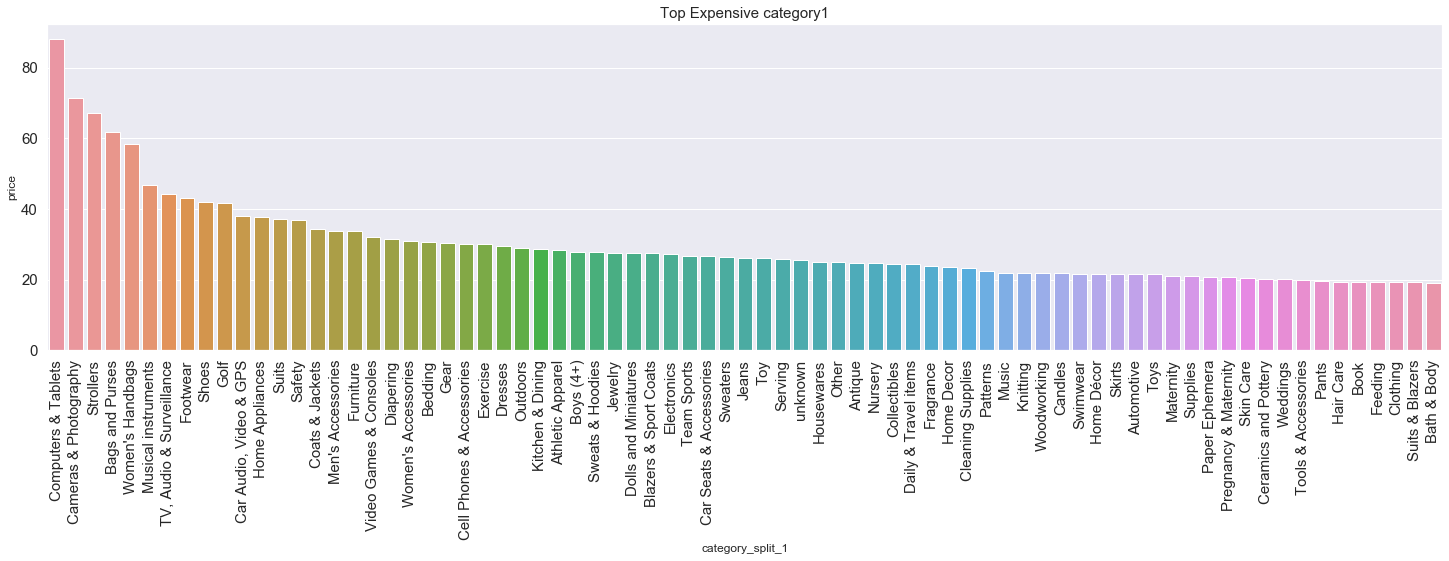

In [24]:
# Display Top 75 category_split_1 By Mean Price
plt.figure(figsize=(25, 6))
category = train_fill.groupby('category_split_1', axis=0).mean()
df_expPrice = pd.DataFrame(category.sort_values('price', ascending = False)['price'][0:75].reset_index())

ax = sns.barplot(x="category_split_1", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top Expensive category1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

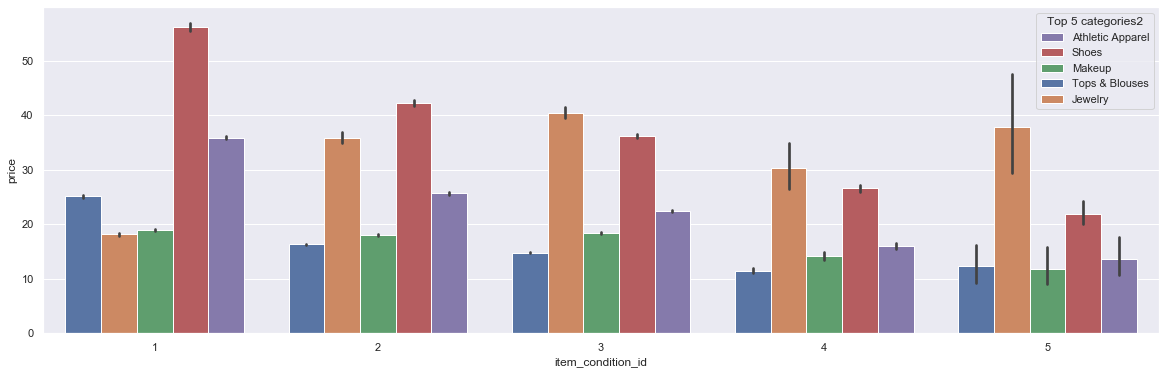

In [25]:
#price comparison by item condition across 5 most frequent Second Main Categories
plt.figure(figsize=(20, 6))
sns.barplot(x='item_condition_id', y="price", hue='category_split_1', data=train_fill[(train_fill['category_split_1'] == train_fill['category_split_1'].value_counts().index[0]) | (train_fill['category_split_1'] == train_fill['category_split_1'].value_counts().index[1]) | (train_fill['category_split_1'] == train_fill['category_split_1'].value_counts().index[2]) | (train_fill['category_split_1'] == train_fill['category_split_1'].value_counts().index[3]) | (train_fill['category_split_1'] == train_fill['category_split_1'].value_counts().index[4])])
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[4], handles[3], handles[2], handles[0], handles[1]]
labels = [labels[4], labels[3], labels[2], labels[0], labels[1]]
plt.legend(handles, labels, title='Top 5 categories2', loc='upper right');

In [26]:
# lets see by third main category or category_split_2 how its priced
thrdcat = train_fill.groupby('category_split_2').price.agg(['count','mean'])
thrdcat = thrdcat[thrdcat['count']>1000].sort_values(by='mean', ascending=False)
thrdcat.head(30)

count        mean
category_split_2                               
Laptops & Netbooks             1783  177.089176
Handbag                        1366  139.664714
Digital Cameras                1346  112.305349
Satchel                        2331  111.720292
Cell Phones & Smartphones      8692  109.184825
Consoles                       4206   90.219448
iPad                           3055   73.680196
Shoulder Bag                  15317   66.022916
Camera & Photo Accessories     1056   60.648674
Messenger & Crossbody          8918   58.978583
Totes & Shoppers               9368   58.416524
Watches                        7646   56.688072
Athletic                      27037   55.760291
Fitness technology             2034   55.214356
Diaper Bags                    1162   48.298623
Asymmetrical Hem               3370   48.091691
Purse                          2067   47.534107
Puffer                         1042   47.333013
Hair                           1293   46.761794
Fashion Sneakers              15193   44.841638
Headphones                     4682   44.262922
Full-Length                    5612   43.750535
Boots                         20258   43.227959
Belts                          2681   43.111712
Gadgets                        1153   42.693842
Backpacks, Bags & Briefcases   1746   42.262887
Backpack Style                 4548   42.235928
Portable Audio & Accessories   2006   40.404536
Sports Nutrition               1407   38.918977
Motorcycle                     1291   37.800930

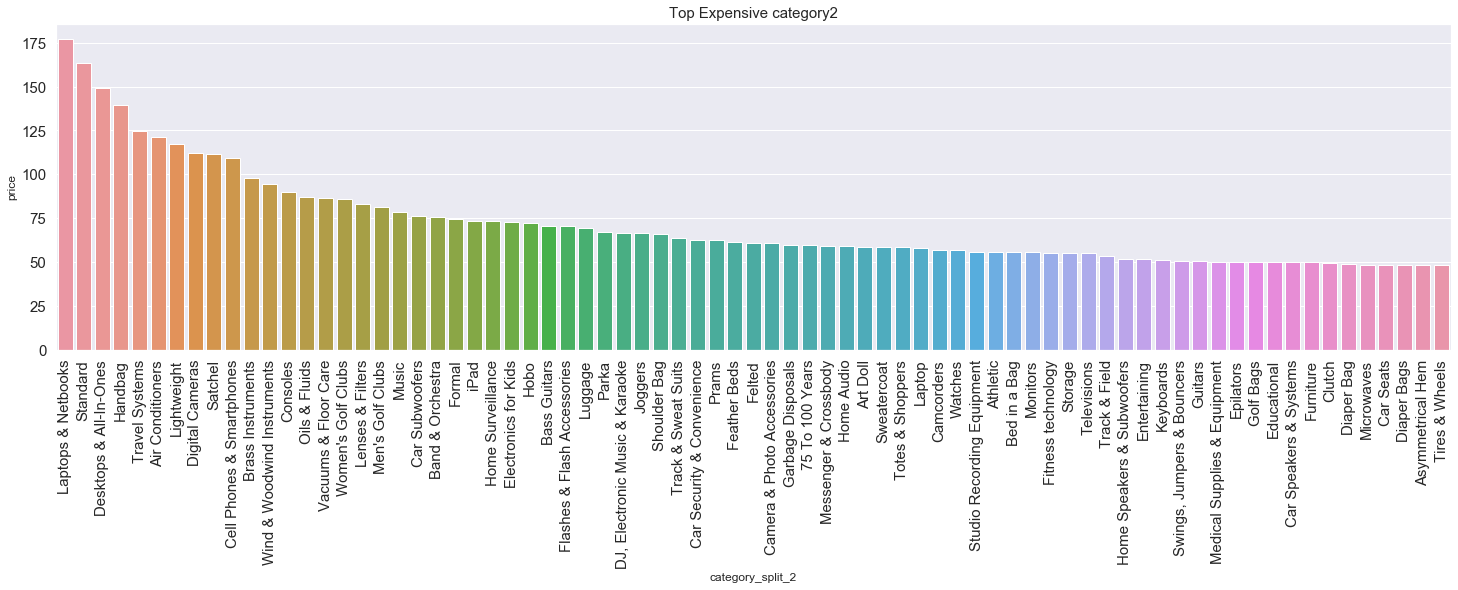

In [27]:
# Display Top 75 category_split_2 By Mean Price
plt.figure(figsize=(25, 6))
top_category2 = train_fill.groupby('category_split_2', axis=0).mean()
df_expPrice = pd.DataFrame(top_category2.sort_values('price', ascending = False)['price'][0:75].reset_index())

ax = sns.barplot(x="category_split_2", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top Expensive category2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

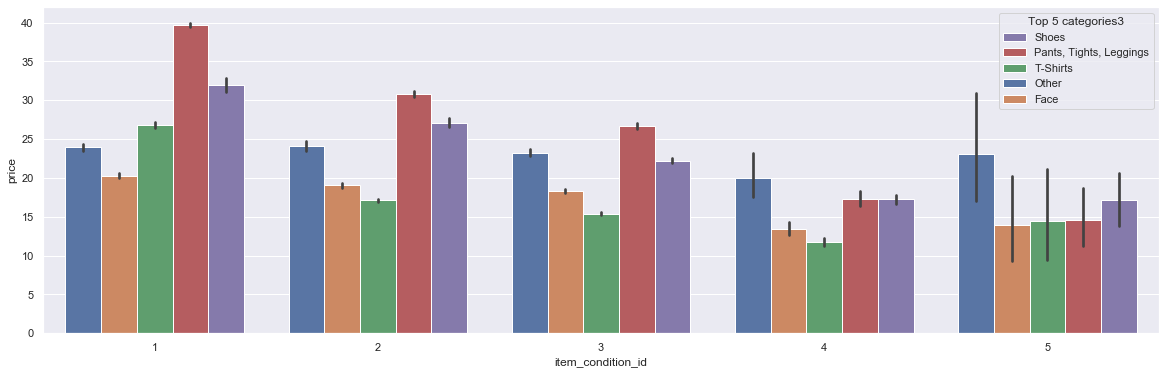

In [28]:
#price comparison by item condition across 5 most frequent Third Main Categories
plt.figure(figsize=(20, 6))
sns.barplot(x='item_condition_id', y="price", hue='category_split_2', data=train_fill[(train_fill['category_split_2'] == train_fill['category_split_2'].value_counts().index[0]) | (train_fill['category_split_2'] == train_fill['category_split_2'].value_counts().index[1]) | (train_fill['category_split_2'] == train_fill['category_split_2'].value_counts().index[2]) | (train_fill['category_split_2'] == train_fill['category_split_2'].value_counts().index[3]) | (train_fill['category_split_2'] == train_fill['category_split_2'].value_counts().index[4])])
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[4], handles[3], handles[2], handles[0], handles[1]]
labels = [labels[4], labels[3], labels[2], labels[0], labels[1]]
plt.legend(handles, labels, title='Top 5 categories3', loc='upper right');

In [29]:
# lets visualize the count by item_condition_id
conditioncnt = train_fill['item_condition_id'].value_counts()
fig = go.Figure([go.Pie(labels=conditioncnt.keys(), values=conditioncnt)])
fig.update_traces( hoverinfo="label+percent")
fig.update_layout(title_text="% by Item Condition")
fig.show()

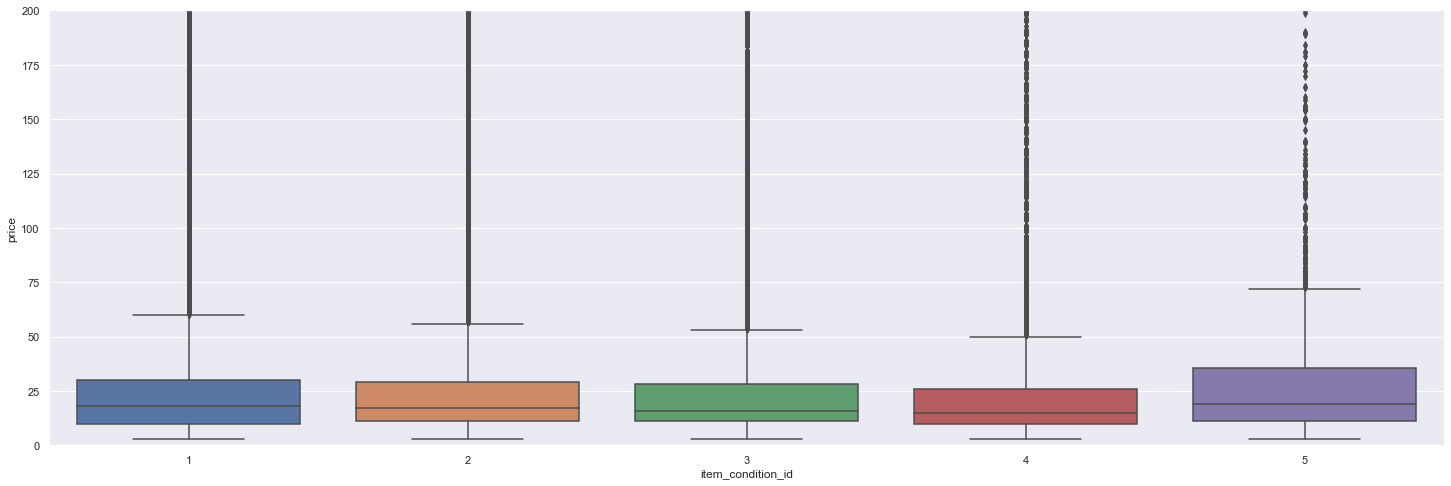

In [30]:
# visualizing the price distribution by Item Condition
plt.figure(figsize=(25, 8))

sns.boxplot(x='item_condition_id', y="price", data=train_fill)
plt.ylim(0, 200);

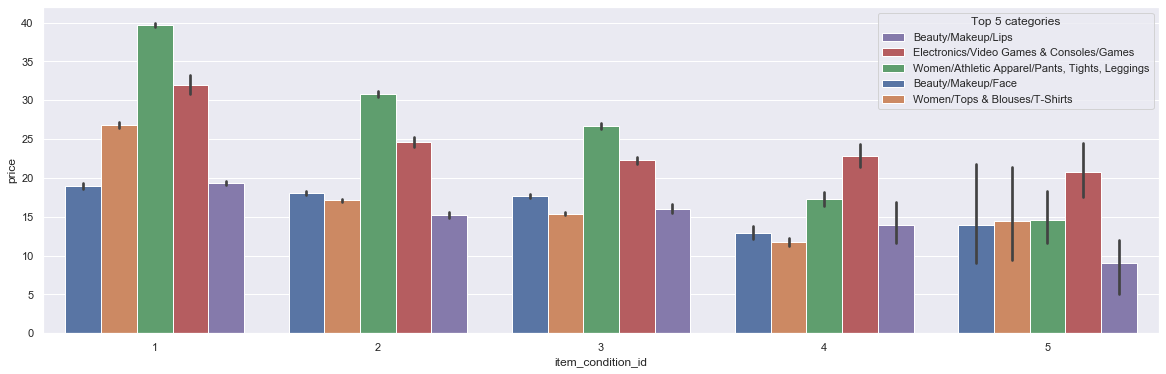

In [31]:
#price comparison by item condition across 5 most frequent Category Names
plt.figure(figsize=(20, 6))
sns.barplot(x='item_condition_id', y="price", hue='category_name', data=train_fill[(train_fill['category_name'] == train_fill['category_name'].value_counts().index[0]) | (train_fill['category_name'] == train_fill['category_name'].value_counts().index[1]) | (train_fill['category_name'] == train_fill['category_name'].value_counts().index[2]) | (train_fill['category_name'] == train_fill['category_name'].value_counts().index[3]) | (train_fill['category_name'] == train_fill['category_name'].value_counts().index[4])])
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[4], handles[3], handles[2], handles[0], handles[1]]
labels = [labels[4], labels[3], labels[2], labels[0], labels[1]]
plt.legend(handles, labels, title='Top 5 categories', loc='upper right');

looking at the graphs and data, as expected brand, categories and condition is influencing the pricing. 

now lets look at the description and see what kinda effect it has on the pricing

## Tokenization & Text Cleaning

In [32]:
# define function for text normalization
import string

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
from nltk.stem.porter import PorterStemmer

def text_normalization(text):
    # lowercase words
    text = text.lower()
    # remove stopwords
    text = ' '.join([i for i in text.split(' ') if i not in stopwords])
    #remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [33]:
%%time

train_fill['item_description_normalized'] = train_fill['item_description'].apply(text_normalization).copy()

CPU times: user 7min 26s, sys: 1.69 s, total: 7min 28s
Wall time: 7min 30s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
%%time

train_fill['name_normalized'] = train_fill['name'].apply(text_normalization).copy()

CPU times: user 1min 51s, sys: 416 ms, total: 1min 51s
Wall time: 1min 52s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
pd.set_option('display.width', 1000)

# check first item description
train_fill['item_description'][:8]

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags. Leather horses. Retail for [rm]...
4            Complete with certificate of authenticity
5    Banana republic bottoms, Candies skirt with ma...
6    Size small but straps slightly shortened to fi...
7    You get three pairs of Sophie cheer shorts siz...
Name: item_description, dtype: object

In [36]:
# check first item description after normalization and compare with previous result
train_fill['item_description_normalized'][:8]

0                                             descript
1    keyboard great condit work like came box port ...
2    ador hint lace key hole back pale pink x x ava...
3    new tag leather hors retail rm each stand foot...
4                               complet certif authent
5    banana republ bottom candi skirt match blazera...
6    size small strap slightli shorten fit xs that ...
7    pair sophi cheer short size small medium girl ...
Name: item_description_normalized, dtype: object

In [37]:
train_fill['name'][:8]

0     MLB Cincinnati Reds T Shirt Size XL
1        Razer BlackWidow Chroma Keyboard
2                          AVA-VIV Blouse
3                   Leather Horse Statues
4                    24K GOLD plated rose
5        Bundled items requested for Ruie
6      Acacia pacific tides santorini top
7    Girls cheer and tumbling bundle of 7
Name: name, dtype: object

In [38]:
train_fill['name_normalized'][:8]

0    mlb cincinnati red t shirt size xl
1      razer blackwidow chroma keyboard
2                          avaviv blous
3                    leather hors statu
4                     k gold plate rose
5               bundl item request ruie
6           acacia pacif tide santorini
7                girl cheer tumbl bundl
Name: name_normalized, dtype: object

(-0.5, 399.5, 199.5, -0.5)

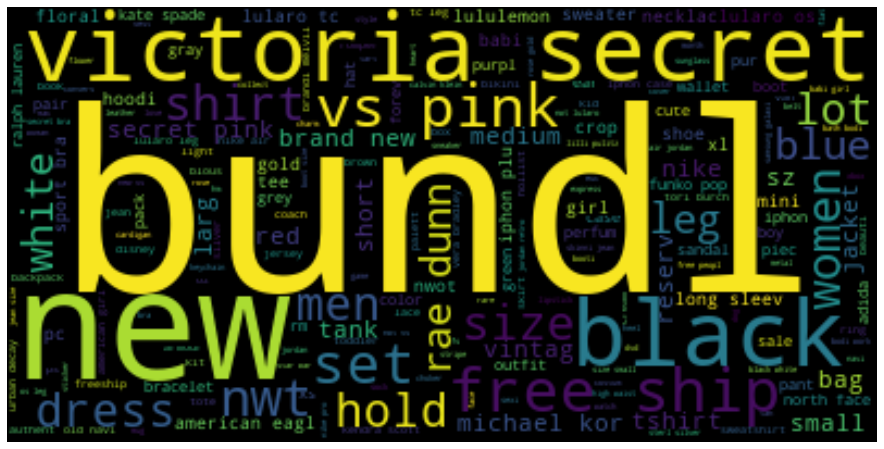

In [39]:
# Generate a word cloud image for name frequency
wordcloud = WordCloud().generate((train_fill['name_normalized'].sample(100000) + ' ').sum())
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

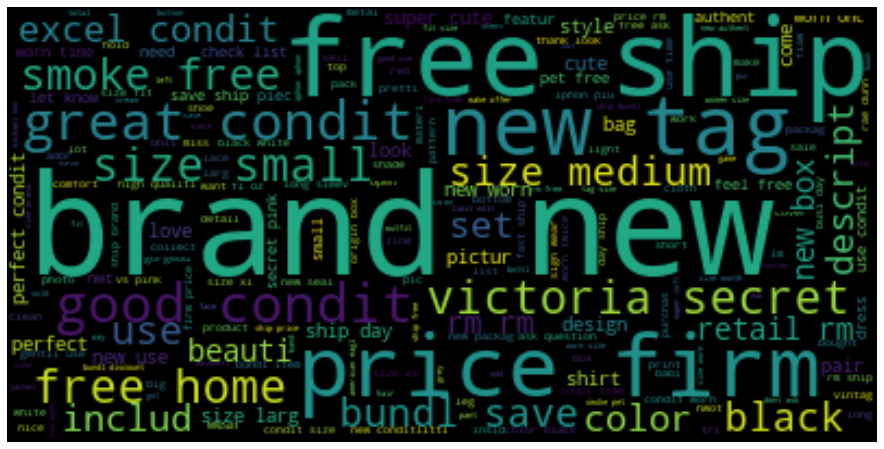

In [40]:
# Generate a word cloud image for description word frequency
wordcloud = WordCloud().generate((train_fill['item_description_normalized'].sample(100000) + ' ').sum())
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Vectorization

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer()

In [42]:
item_description_bow = vectorizer.fit_transform(train_fill['item_description_normalized'])
item_description_bow

<1481661x191298 sparse matrix of type '<class 'numpy.int64'>'
	with 20667981 stored elements in Compressed Sparse Row format>